Iteration 1, loss = 0.07154651
Iteration 2, loss = 0.06826784
Iteration 3, loss = 0.06821138
Iteration 4, loss = 0.06812507
Iteration 5, loss = 0.06808516
Iteration 6, loss = 0.06807455
Iteration 7, loss = 0.06804769
Iteration 8, loss = 0.06801968
Iteration 9, loss = 0.06803250
Iteration 10, loss = 0.06801938
Iteration 11, loss = 0.06800702
Iteration 12, loss = 0.06799336
Iteration 13, loss = 0.06798093
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


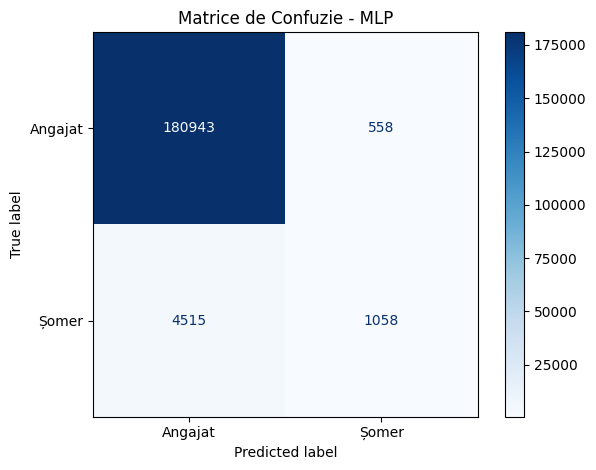

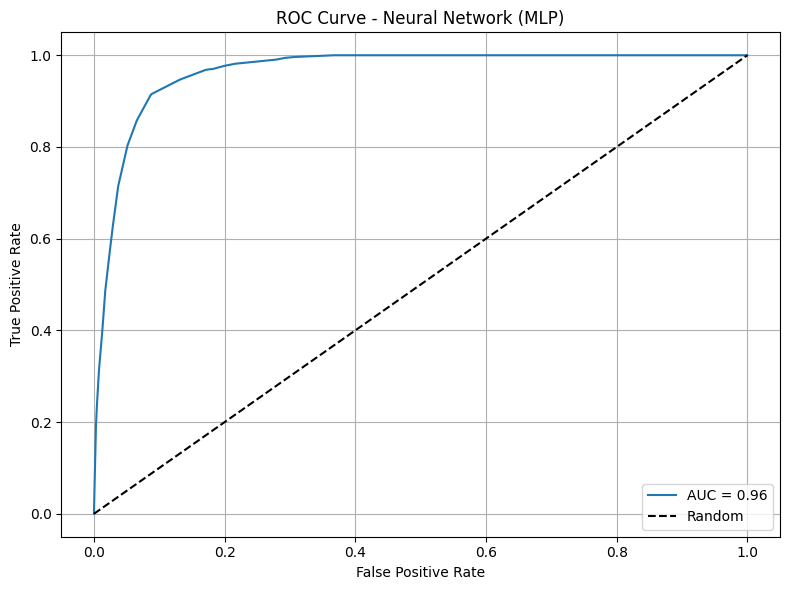


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    181501
           1       0.65      0.19      0.29      5573

    accuracy                           0.97    187074
   macro avg       0.82      0.59      0.64    187074
weighted avg       0.97      0.97      0.97    187074



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

# === Încarcă datele pentru 2010-2013 ===
dfs = []
for year in ['2010', '2011', '2012', '2013']:
    df = pd.read_csv(f"../data/raw/RO_LFS_{year}_Y.csv", low_memory=False)
    df['YEAR'] = int(year)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# === Selectează variabilele ===
features = ['SEX', 'AGE', 'EDUCSTAT', 'DEGURBA', 'STAPRO', 'TEMP', 'FTPT', 'COURATT']
target = 'ILOSTAT'
data = data[features + [target]].copy()

# === Pregătește targetul binar ===
data = data[data[target].notna()]
data[target] = (data[target] == 2).astype(int)
data.dropna(subset=features + [target], inplace=True)

# === One-hot encoding ===
data_encoded = pd.get_dummies(data, columns=features, drop_first=True)

# === Train/Test split ===
X = data_encoded.drop(columns=[target])
y = data_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Normalizează ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Rețea neuronală (MLPClassifier) ===
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=30,
    random_state=42,
    verbose=True
)
mlp.fit(X_train_scaled, y_train)

# === Predictii ===
y_pred = mlp.predict(X_test_scaled)
y_prob = mlp.predict_proba(X_test_scaled)[:, 1]

# === Matrice de confuzie ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Angajat", "Șomer"])
disp.plot(cmap="Blues")
plt.title("Matrice de Confuzie - MLP")
plt.tight_layout()
plt.grid(False)
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network (MLP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Classification report ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
